# Jackson Networks with Risk-Adjusted Bellman Scheduling

This notebook explores optimal scheduling in Jackson queueing networks using:
- **Risk-adjusted Bellman equations** for queue insertion decisions
- **Mean field limits** for large-scale network behavior
- **Interval trees** for managing queue slots and capacity
- **Stochastic routing** with probabilistic job flows

## Mathematical Framework

### Jackson Network Model
- **Stations**: $i \in \{1, ..., M\}$ with service rates $\mu_i$
- **Routing**: Probability $p_{ij}$ of job moving from station $i$ to $j$
- **External arrivals**: Poisson with rate $\lambda_i$ at station $i$
- **Queue dynamics**: $Q_i(t)$ = queue length at station $i$, time $t$

### Risk-Adjusted Bellman Equation
$$V(\mathbf{Q}, t) = \max_{a \in \mathcal{A}} \left[ R(\mathbf{Q}, a) + \gamma \mathbb{E}[V(\mathbf{Q}', t+1) | \mathbf{Q}, a] - \lambda \cdot \text{Risk}(\mathbf{Q}, a) \right]$$

Where:
- $\mathbf{Q} = (Q_1, ..., Q_M)$ is the network state
- $\text{Risk}(\mathbf{Q}, a) = \mathbb{P}(\text{overflow or deadline miss})$
- Actions $a$ include: queue insertion position, routing decisions, priority assignments

### Mean Field Limit
As $N \to \infty$ (number of jobs), the empirical distribution converges:
$$\frac{1}{N} \sum_{n=1}^N \delta_{X_n(t)} \to \mu_t \text{ (deterministic measure)}$$


In [1]:
# Setup and imports
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, FancyBboxPatch
from matplotlib.animation import FuncAnimation
import seaborn as sns
from dataclasses import dataclass, field
from typing import List, Dict, Tuple, Optional, Set
import random
import math
from collections import defaultdict, deque
from scipy import stats
from scipy.optimize import minimize
import networkx as nx
from IPython.display import display, HTML
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
project_root = Path().absolute().parent
sys.path.insert(0, str(project_root))

# Import interval tree
from treemendous.cpp.boundary import IntervalManager

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("🌐 Jackson Network Bellman Scheduler initialized!")
print(f"📊 Using interval trees from: {project_root}")


🌐 Jackson Network Bellman Scheduler initialized!
📊 Using interval trees from: /Users/joseph/dev/Tree-Mendous


## Network Components and Data Structures


In [2]:
@dataclass
class Station:
    """A station in the Jackson network"""
    id: int
    name: str
    service_rate: float  # μ_i: jobs per time unit
    capacity: int  # Maximum queue length
    holding_cost: float  # Cost per job per time unit
    overflow_penalty: float  # Cost for rejecting a job
    
    def service_time_sample(self) -> float:
        """Sample exponential service time"""
        return np.random.exponential(1.0 / self.service_rate)
    
    def mean_service_time(self) -> float:
        return 1.0 / self.service_rate

@dataclass
class Job:
    """A job in the network"""
    id: int
    arrival_time: float
    due_date: float
    value: float
    current_station: Optional[int] = None
    route_history: List[int] = field(default_factory=list)
    completion_time: Optional[float] = None
    queue_insertions: List[Tuple[int, int]] = field(default_factory=list)  # (station, position)
    
    def tardiness_risk(self, current_time: float, remaining_stations: List[Station]) -> float:
        """Calculate probability of missing due date"""
        if not remaining_stations:
            return 0.0
        
        # Sum of exponential service times → Gamma distribution
        total_mean = sum(s.mean_service_time() for s in remaining_stations)
        total_variance = sum((1.0/s.service_rate)**2 for s in remaining_stations)
        
        time_remaining = self.due_date - current_time
        if time_remaining <= 0:
            return 1.0
        
        # Normal approximation for sum of exponentials
        z_score = (time_remaining - total_mean) / math.sqrt(total_variance)
        return 1.0 - stats.norm.cdf(z_score)

@dataclass
class NetworkState:
    """Complete state of the Jackson network"""
    queue_lengths: Dict[int, int]  # Station ID → current queue length
    queue_contents: Dict[int, deque]  # Station ID → deque of Job IDs
    in_service: Dict[int, Optional[int]]  # Station ID → Job ID being served
    time: float
    total_jobs: int
    completed_jobs: int
    rejected_jobs: int
    
    def congestion_level(self, station_id: int, capacity: int) -> float:
        """Congestion metric for a station (0-1)"""
        return self.queue_lengths.get(station_id, 0) / capacity
    
    def network_load(self, stations: Dict[int, Station]) -> float:
        """Overall network congestion"""
        total_congestion = sum(
            self.congestion_level(sid, s.capacity) 
            for sid, s in stations.items()
        )
        return total_congestion / len(stations)

print("✅ Data structures defined for Jackson network")


✅ Data structures defined for Jackson network


## Jackson Network Configuration


In [3]:
class JacksonNetwork:
    """Jackson queueing network with probabilistic routing"""
    
    def __init__(self, stations: List[Station], routing_matrix: np.ndarray, 
                 external_arrivals: Dict[int, float]):
        """
        Args:
            stations: List of stations in the network
            routing_matrix: P[i,j] = probability of routing from station i to j
                          P[i,-1] = probability of leaving the network
            external_arrivals: Station ID → Poisson arrival rate
        """
        self.stations = {s.id: s for s in stations}
        self.routing_matrix = routing_matrix
        self.external_arrivals = external_arrivals
        self.n_stations = len(stations)
        
        # Validate routing matrix
        assert routing_matrix.shape == (self.n_stations, self.n_stations + 1)
        assert np.allclose(routing_matrix.sum(axis=1), 1.0), "Routing probabilities must sum to 1"
        
        # Calculate traffic equations (λ = γ + λP)
        self.traffic_intensities = self._solve_traffic_equations()
        
        # Interval trees for each station's queue slots
        self.queue_trees = {}
        for sid, station in self.stations.items():
            tree = IntervalManager()
            tree.release_interval(0, station.capacity)
            self.queue_trees[sid] = tree
    
    def _solve_traffic_equations(self) -> Dict[int, float]:
        """Solve λ = γ + λP for effective arrival rates"""
        # Extract internal routing (exclude exit probabilities)
        P_internal = self.routing_matrix[:, :-1]
        
        # External arrival vector
        gamma = np.array([self.external_arrivals.get(i, 0) for i in range(self.n_stations)])
        
        # Solve (I - P)λ = γ
        I_minus_P = np.eye(self.n_stations) - P_internal.T
        lambda_effective = np.linalg.solve(I_minus_P, gamma)
        
        return {i: lambda_effective[i] for i in range(self.n_stations)}
    
    def utilization(self, station_id: int) -> float:
        """Calculate theoretical utilization ρ_i = λ_i / μ_i"""
        lambda_i = self.traffic_intensities[station_id]
        mu_i = self.stations[station_id].service_rate
        return lambda_i / mu_i
    
    def is_stable(self) -> bool:
        """Check if network is stable (all ρ_i < 1)"""
        return all(self.utilization(sid) < 1.0 for sid in self.stations)
    
    def route_job(self, from_station: int) -> Optional[int]:
        """Sample next station according to routing probabilities"""
        probs = self.routing_matrix[from_station]
        next_station = np.random.choice(self.n_stations + 1, p=probs)
        
        if next_station == self.n_stations:  # Exit network
            return None
        return next_station

# Create example network: Manufacturing with rework loops
def create_manufacturing_network():
    """Create a Jackson network for manufacturing with quality control"""
    
    stations = [
        Station(0, "Machining", service_rate=3.0, capacity=20, 
                holding_cost=10, overflow_penalty=500),
        Station(1, "Assembly", service_rate=2.5, capacity=15, 
                holding_cost=15, overflow_penalty=600),
        Station(2, "Testing", service_rate=4.0, capacity=10, 
                holding_cost=20, overflow_penalty=400),
        Station(3, "Rework", service_rate=1.5, capacity=8, 
                holding_cost=30, overflow_penalty=800),
        Station(4, "Packaging", service_rate=5.0, capacity=12, 
                holding_cost=5, overflow_penalty=300),
    ]
    
    # Routing matrix: [to_0, to_1, to_2, to_3, to_4, exit]
    routing = np.array([
        [0.0, 0.9, 0.0, 0.0, 0.0, 0.1],  # Machining → Assembly (90%), Exit (10%)
        [0.0, 0.0, 0.95, 0.0, 0.0, 0.05], # Assembly → Testing (95%), Exit (5%)
        [0.0, 0.0, 0.0, 0.15, 0.8, 0.05], # Testing → Rework (15%), Packaging (80%), Exit (5%)
        [0.3, 0.6, 0.0, 0.0, 0.0, 0.1],   # Rework → Machining (30%), Assembly (60%), Exit (10%)
        [0.0, 0.0, 0.0, 0.0, 0.0, 1.0],   # Packaging → Exit (100%)
    ])
    
    # External arrivals (only at Machining)
    external_arrivals = {0: 2.0}  # 2 jobs/time unit arrive at Machining
    
    return JacksonNetwork(stations, routing, external_arrivals)

# Create and analyze network
network = create_manufacturing_network()

print("📊 Jackson Network Created:")
print(f"  Stations: {len(network.stations)}")
print(f"  Stable: {network.is_stable()}")
print("\n🔄 Traffic Intensities (λ_i):")
for sid, lambda_i in network.traffic_intensities.items():
    station = network.stations[sid]
    rho = network.utilization(sid)
    print(f"  {station.name}: λ={lambda_i:.2f}, μ={station.service_rate:.2f}, ρ={rho:.2%}")


📊 Jackson Network Created:
  Stations: 5
  Stable: True

🔄 Traffic Intensities (λ_i):
  Machining: λ=2.09, μ=3.00, ρ=69.59%
  Assembly: λ=2.05, μ=2.50, ρ=82.19%
  Testing: λ=1.95, μ=4.00, ρ=48.80%
  Rework: λ=0.29, μ=1.50, ρ=19.52%
  Packaging: λ=1.56, μ=5.00, ρ=31.23%


## Risk-Adjusted Bellman Scheduler


In [4]:
class BellmanQueueScheduler:
    """Bellman-based scheduler with queue insertion optimization"""
    
    def __init__(self, network: JacksonNetwork, risk_weight: float = 0.5, 
                 discount: float = 0.95):
        self.network = network
        self.risk_weight = risk_weight
        self.discount = discount
        self.value_function = {}  # Cache for value function
        self.policy = {}  # Learned policy
        self.mean_field_limit = None  # Mean field approximation
    
    def state_signature(self, state: NetworkState) -> str:
        """Compact state representation for value function"""
        # Discretize queue lengths into buckets
        buckets = []
        for sid in sorted(self.network.stations.keys()):
            q_len = state.queue_lengths.get(sid, 0)
            capacity = self.network.stations[sid].capacity
            bucket = min(4, int(4 * q_len / capacity))  # 5 buckets: 0-20%, 20-40%, ...
            buckets.append(bucket)
        
        # Include network load level
        load_bucket = min(4, int(4 * state.network_load(self.network.stations)))
        
        return f"{''.join(map(str, buckets))}_{load_bucket}"
    
    def queue_insertion_value(self, job: Job, station_id: int, position: int, 
                              state: NetworkState) -> float:
        """Value of inserting job at specific queue position"""
        station = self.network.stations[station_id]
        
        # Base reward from job value
        reward = job.value
        
        # Position penalty (prefer earlier positions)
        position_penalty = position * station.holding_cost
        reward -= position_penalty
        
        # Congestion penalty
        congestion = state.congestion_level(station_id, station.capacity)
        congestion_penalty = congestion * station.holding_cost * 10
        reward -= congestion_penalty
        
        # Risk penalty for tardiness
        remaining_stations = self._get_remaining_stations(job, station_id)
        tardiness_risk = job.tardiness_risk(state.time, remaining_stations)
        risk_penalty = tardiness_risk * job.value * self.risk_weight
        reward -= risk_penalty
        
        # Future value (discounted)
        future_state_sig = self.state_signature(state)
        future_value = self.value_function.get(future_state_sig, 0)
        reward += self.discount * future_value
        
        return reward
    
    def _get_remaining_stations(self, job: Job, current_station: int) -> List[Station]:
        """Estimate remaining stations in job's path"""
        remaining = []
        station = current_station
        
        # Follow most likely path through network
        for _ in range(10):  # Max 10 hops to prevent infinite loops
            next_station_probs = self.network.routing_matrix[station]
            next_station = np.argmax(next_station_probs[:-1])  # Most likely next (exclude exit)
            
            if next_station_probs[next_station] < 0.1:  # Likely to exit
                break
            
            remaining.append(self.network.stations[next_station])
            station = next_station
        
        return remaining
    
    def decide_queue_insertion(self, job: Job, station_id: int, 
                              state: NetworkState) -> Tuple[bool, int]:
        """Decide whether to accept job and where to insert in queue"""
        station = self.network.stations[station_id]
        current_queue_length = state.queue_lengths.get(station_id, 0)
        
        # Check if queue is full
        if current_queue_length >= station.capacity:
            return False, -1  # Reject job
        
        # Evaluate all possible insertion positions
        best_position = current_queue_length  # Default: end of queue
        best_value = float('-inf')
        
        for position in range(current_queue_length + 1):
            value = self.queue_insertion_value(job, station_id, position, state)
            
            if value > best_value:
                best_value = value
                best_position = position
        
        # Reject if value is negative (overflow penalty)
        if best_value < -station.overflow_penalty:
            return False, -1
        
        return True, best_position
    
    def learn_value_function(self, episodes: int = 100, horizon: int = 500):
        """Learn value function through simulation"""
        print(f"\n🧠 Learning value function ({episodes} episodes)...")
        
        for episode in range(episodes):
            # Simulate episode and collect rewards
            states, actions, rewards = self._simulate_episode(horizon)
            
            # Update value function using TD learning
            for t in range(len(states) - 1):
                state_sig = self.state_signature(states[t])
                next_state_sig = self.state_signature(states[t + 1])
                
                # TD error
                current_v = self.value_function.get(state_sig, 0)
                next_v = self.value_function.get(next_state_sig, 0)
                td_error = rewards[t] + self.discount * next_v - current_v
                
                # Update with learning rate
                alpha = 0.1 / (1 + episode * 0.01)  # Decaying learning rate
                self.value_function[state_sig] = current_v + alpha * td_error
            
            if (episode + 1) % 20 == 0:
                avg_value = np.mean(list(self.value_function.values()))
                print(f"  Episode {episode + 1}: Avg V = {avg_value:.2f}")
        
        print(f"✅ Learned {len(self.value_function)} state values")
    
    def _simulate_episode(self, horizon: int) -> Tuple[List, List, List]:
        """Simulate one episode of the network"""
        # Initialize state
        state = NetworkState(
            queue_lengths={sid: 0 for sid in self.network.stations},
            queue_contents={sid: deque() for sid in self.network.stations},
            in_service={sid: None for sid in self.network.stations},
            time=0,
            total_jobs=0,
            completed_jobs=0,
            rejected_jobs=0
        )
        
        states = []
        actions = []
        rewards = []
        
        jobs = self._generate_jobs(horizon)
        job_idx = 0
        
        for t in range(horizon):
            state.time = t
            states.append(state)
            
            # Process arrivals
            episode_reward = 0
            while job_idx < len(jobs) and jobs[job_idx].arrival_time <= t:
                job = jobs[job_idx]
                
                # Initial station (Machining)
                station_id = 0
                accept, position = self.decide_queue_insertion(job, station_id, state)
                
                if accept:
                    state.queue_contents[station_id].insert(position, job.id)
                    state.queue_lengths[station_id] += 1
                    job.queue_insertions.append((station_id, position))
                    episode_reward += job.value
                else:
                    state.rejected_jobs += 1
                    episode_reward -= self.network.stations[station_id].overflow_penalty
                
                actions.append(("insert", station_id, position))
                job_idx += 1
            
            # Process services (simplified)
            for sid in self.network.stations:
                if state.queue_lengths.get(sid, 0) > 0:
                    # Holding cost
                    episode_reward -= (state.queue_lengths[sid] * 
                                     self.network.stations[sid].holding_cost)
            
            rewards.append(episode_reward)
        
        return states, actions, rewards
    
    def _generate_jobs(self, horizon: int) -> List[Job]:
        """Generate jobs with Poisson arrivals"""
        jobs = []
        job_id = 0
        
        for station_id, arrival_rate in self.network.external_arrivals.items():
            # Generate Poisson arrivals
            n_arrivals = np.random.poisson(arrival_rate * horizon)
            arrival_times = np.sort(np.random.uniform(0, horizon, n_arrivals))
            
            for arrival_time in arrival_times:
                # Estimate processing time through network
                total_processing = sum(s.mean_service_time() 
                                     for s in self.network.stations.values())
                
                due_date = arrival_time + total_processing * random.uniform(1.5, 3.0)
                value = random.uniform(50, 200) * (1.0 + 1.0 / (1 + total_processing))
                
                jobs.append(Job(
                    id=job_id,
                    arrival_time=arrival_time,
                    due_date=due_date,
                    value=value,
                    current_station=station_id
                ))
                job_id += 1
        
        return sorted(jobs, key=lambda j: j.arrival_time)

# Create and train scheduler
scheduler = BellmanQueueScheduler(network, risk_weight=0.3)
scheduler.learn_value_function(episodes=50, horizon=200)



🧠 Learning value function (50 episodes)...
  Episode 20: Avg V = -22201.25
  Episode 40: Avg V = -22748.64
✅ Learned 1 state values


## Mean Field Limit Analysis



🌊 Computing mean field limit (N=500)...
  t=0: Distribution entropy = 1.607
  t=100: Distribution entropy = 0.748
  t=200: Distribution entropy = 0.759

📊 Mean Field Steady State:
  Machining: 0.070
  Assembly: 0.082
  Testing: 0.050
  Rework: 0.018
  Packaging: 0.030


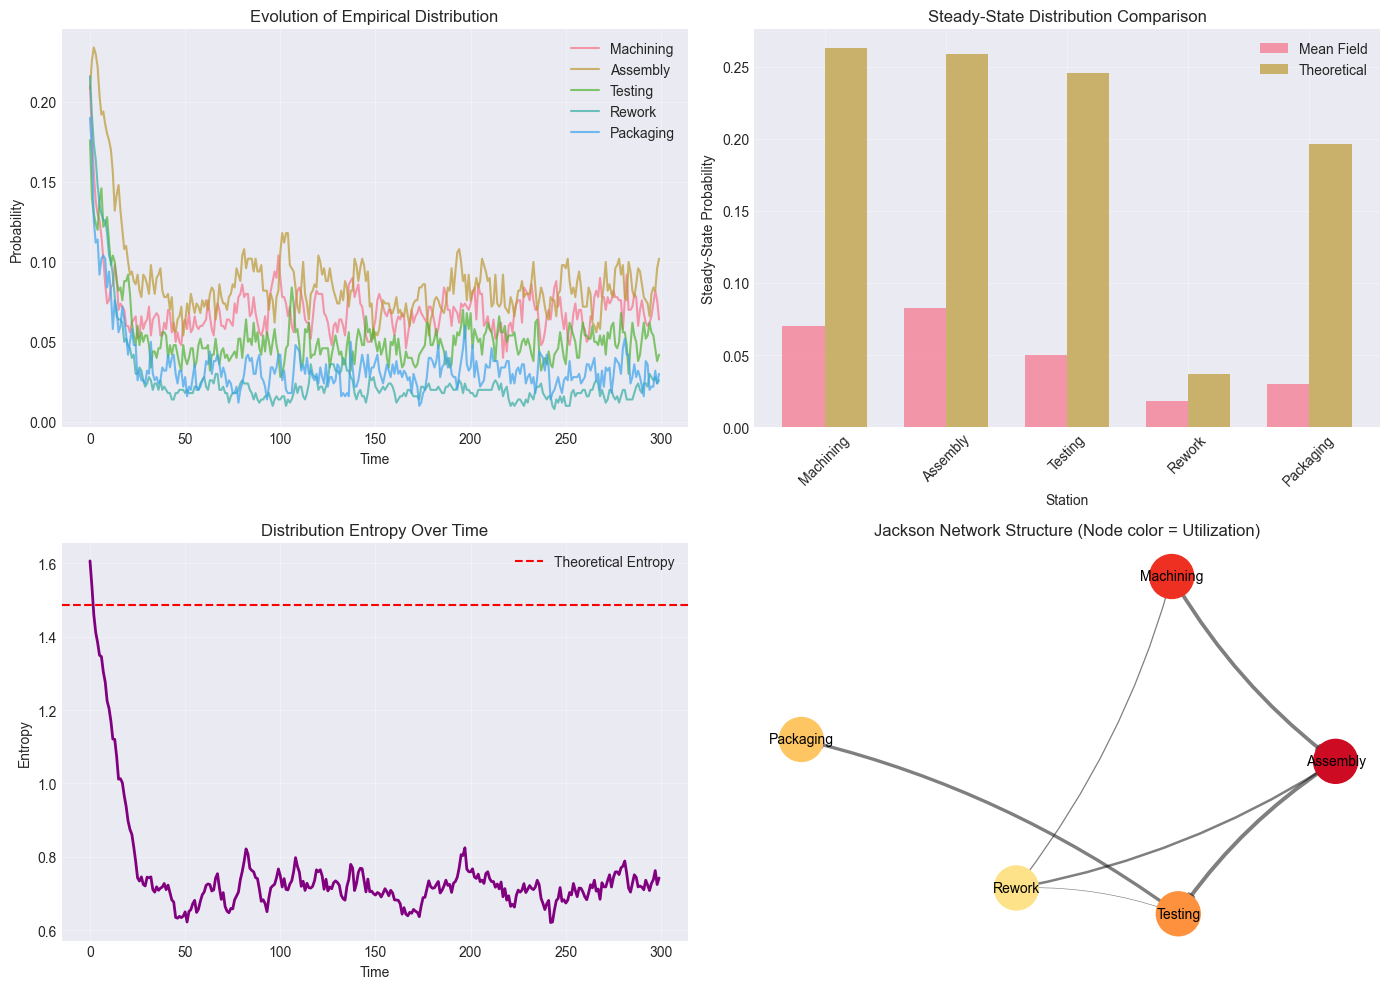

In [5]:
class MeanFieldAnalysis:
    """Mean field limit analysis for large-scale networks"""
    
    def __init__(self, network: JacksonNetwork):
        self.network = network
        self.mean_field_state = None
        self.convergence_history = []
    
    def compute_mean_field_limit(self, n_particles: int = 1000, 
                                 time_steps: int = 500) -> np.ndarray:
        """Compute mean field limit through particle simulation"""
        print(f"\n🌊 Computing mean field limit (N={n_particles})...")
        
        # Initialize particles (jobs) uniformly across stations
        particles = np.random.choice(list(self.network.stations.keys()), 
                                    size=n_particles)
        
        # Track empirical distribution over time
        empirical_dist = np.zeros((time_steps, len(self.network.stations)))
        
        for t in range(time_steps):
            # Current empirical distribution
            for sid in self.network.stations:
                empirical_dist[t, sid] = np.sum(particles == sid) / n_particles
            
            # Update particles (simulate transitions)
            new_particles = []
            for particle in particles:
                # Service completion with rate μ
                if np.random.random() < self.network.stations[particle].service_rate / 10:
                    # Route to next station
                    next_station = self.network.route_job(particle)
                    if next_station is not None:
                        new_particles.append(next_station)
                    # else: particle exits
                else:
                    new_particles.append(particle)
            
            # Add new arrivals
            for sid, rate in self.network.external_arrivals.items():
                n_new = np.random.poisson(rate * n_particles / 100)
                new_particles.extend([sid] * n_new)
            
            particles = np.array(new_particles[:n_particles])  # Keep population fixed
            
            if t % 100 == 0:
                print(f"  t={t}: Distribution entropy = {self._entropy(empirical_dist[t]):.3f}")
        
        # Compute steady-state (last 20% of simulation)
        steady_state_start = int(0.8 * time_steps)
        self.mean_field_state = empirical_dist[steady_state_start:].mean(axis=0)
        
        print("\n📊 Mean Field Steady State:")
        for sid, prob in enumerate(self.mean_field_state):
            print(f"  {self.network.stations[sid].name}: {prob:.3f}")
        
        return empirical_dist
    
    def _entropy(self, dist: np.ndarray) -> float:
        """Compute entropy of distribution"""
        dist = dist[dist > 0]  # Remove zeros
        return -np.sum(dist * np.log(dist))
    
    def theoretical_steady_state(self) -> np.ndarray:
        """Compute theoretical steady-state using traffic equations"""
        # Normalize traffic intensities
        total_traffic = sum(self.network.traffic_intensities.values())
        theoretical = np.array([
            self.network.traffic_intensities[sid] / total_traffic
            for sid in sorted(self.network.stations.keys())
        ])
        return theoretical
    
    def plot_convergence(self, empirical_dist: np.ndarray):
        """Plot convergence to mean field limit"""
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        
        # Plot 1: Evolution of empirical distribution
        ax = axes[0, 0]
        for sid in self.network.stations:
            ax.plot(empirical_dist[:, sid], 
                   label=self.network.stations[sid].name, alpha=0.7)
        ax.set_xlabel('Time')
        ax.set_ylabel('Probability')
        ax.set_title('Evolution of Empirical Distribution')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Plot 2: Steady state comparison
        ax = axes[0, 1]
        theoretical = self.theoretical_steady_state()
        station_names = [self.network.stations[sid].name 
                        for sid in sorted(self.network.stations.keys())]
        
        x = np.arange(len(station_names))
        width = 0.35
        ax.bar(x - width/2, self.mean_field_state, width, 
               label='Mean Field', alpha=0.7)
        ax.bar(x + width/2, theoretical, width, 
               label='Theoretical', alpha=0.7)
        ax.set_xlabel('Station')
        ax.set_ylabel('Steady-State Probability')
        ax.set_title('Steady-State Distribution Comparison')
        ax.set_xticks(x)
        ax.set_xticklabels(station_names, rotation=45)
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Plot 3: Entropy evolution
        ax = axes[1, 0]
        entropy_curve = [self._entropy(empirical_dist[t]) 
                        for t in range(len(empirical_dist))]
        ax.plot(entropy_curve, color='purple', linewidth=2)
        ax.set_xlabel('Time')
        ax.set_ylabel('Entropy')
        ax.set_title('Distribution Entropy Over Time')
        ax.grid(True, alpha=0.3)
        ax.axhline(y=self._entropy(theoretical), color='red', 
                  linestyle='--', label='Theoretical Entropy')
        ax.legend()
        
        # Plot 4: Network visualization
        ax = axes[1, 1]
        G = nx.DiGraph()
        
        # Add nodes
        for sid, station in self.network.stations.items():
            G.add_node(station.name, 
                      utilization=self.network.utilization(sid))
        
        # Add edges with routing probabilities
        for i, station_i in self.network.stations.items():
            for j, station_j in self.network.stations.items():
                prob = self.network.routing_matrix[i, j]
                if prob > 0.01:
                    G.add_edge(station_i.name, station_j.name, weight=prob)
        
        pos = nx.spring_layout(G, k=2, iterations=50)
        
        # Draw network
        node_colors = [G.nodes[node]['utilization'] 
                      for node in G.nodes()]
        nx.draw_networkx_nodes(G, pos, node_color=node_colors, 
                              cmap='YlOrRd', vmin=0, vmax=1,
                              node_size=1000, ax=ax)
        nx.draw_networkx_labels(G, pos, font_size=10, ax=ax)
        
        # Draw edges with varying thickness
        for edge in G.edges(data=True):
            nx.draw_networkx_edges(G, pos, [(edge[0], edge[1])],
                                  width=edge[2]['weight'] * 3,
                                  alpha=0.5, ax=ax,
                                  connectionstyle="arc3,rad=0.1")
        
        ax.set_title('Jackson Network Structure (Node color = Utilization)')
        ax.axis('off')
        
        plt.tight_layout()
        plt.show()

# Perform mean field analysis
mf_analysis = MeanFieldAnalysis(network)
empirical_dist = mf_analysis.compute_mean_field_limit(n_particles=500, time_steps=300)
mf_analysis.plot_convergence(empirical_dist)
